<a href="https://colab.research.google.com/github/dtht2d/bispectrum_component/blob/main/bispectrum/example/study_example_SO4_calc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Study different cases for calculation SO4

### Import libraries

In [ ]:
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.1 MB/s eta 0:00:00


In [ ]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.3 MB/s eta 0:00:00
time: 668 µs (started: 2023-06-09 19:36:03 +00:00)


In [ ]:
import numpy as np
import json
import pandas as pd
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
from typing import Dict

fact_cache = {}
def fact(n):
    if n < 0 or not np.isclose(n, int(n)):
        raise ValueError("Invalid input parameter: n must be a non-negative integer.")
    if n in fact_cache:
        return fact_cache[n]
    result = np.math.factorial(int(n))
    fact_cache[n] = result
    return result
class Bispectrum:
    """
    Calculate bispectrum- S(0)4 components
    """
    def __init__(self, j, j1, j2 , params: Dict[str, np.ndarray]):
        '''
            j: j index
            j1: j1 index
            j2: j2 index
            input_data: input data dictionary with extracted values:
            r_ik (array): dictance from center atom to n neighbor atom, dim = [n,]
            theta_0 (array): first angle of rotation [0, pi] , dim = [n,]
            theta (array): second angle of rotation [0, pi], dim = [n,]
            phi (array): third angle of rotation [0, 2pi], dim = [n,]
            w_ik (array): weight coefficient, dim = [n,]
            delta (array): delta function, dim = [n,]
            r_cut (array): cutoff distance, dim = [n,]
        '''
        self.j = j
        self.j1 = j1
        self.j2 = j2
        self.params = params
        w_ik_array = self.params['w_ik']
        delta_array = self.params['delta']
        r_ik_array = self.params['r_ik']
        r_cut_array = self.params['r_cut']
        theta_0_array = self.params['theta_0']
        theta_array = self.params['theta']
        phi_array = self.params['phi']
        #Condition check
        if not (abs(j1 - j2) <= j <= j1 + j2 and j1 + j2 - j % 1 != 0.5):
            raise ValueError("Invalid input parameters: j1, j2, j must satisfy the triangle inequality.\ "
                             "j1+j2-j must not be a half-integer")
        J = (j1 + j2 + j)
        if J < (int(j1 + j2 + j)) and J < 0:
            raise ValueError("Invalid input parameters: j1, j2, j must not exceed a positive integer J")

    @staticmethod
    def generate_m_values(j, j1, j2):
        """
        This function generates (m1, m2, m, m1p, m2p, mp) from input set (j1,j2,j)
        and only keeps sets that satisfy the conditions.
        Return: a one and only unique set (m1, m2, m, m1p, m2p, mp)
        """
        J = j1 + j2 + j
        # Condition 1
        if not ((abs(j1 - j2) <= j <= j1 + j2) or isinstance(J, int) or (J >= 0)):
            raise ValueError("Condition (1) is not satisfied.")
        # Condition 2
        if not ((isinstance(val, int) or val >= 0 for val in [j + j1 - j2, j - j1 + j2, j1 + j2 - j])):
            raise ValueError("(𝑗+𝑗1−𝑗2) and (𝑗−𝑗1+𝑗2) and (𝑗1+𝑗2−𝑗) and is non-negative integer")
        # Condition 3
        if j1 > J or j2 > J or j > J:
            raise ValueError("𝑗1,𝑗2,𝑗 not exceed a positive integer 𝐽=𝑗1+𝑗2+𝑗")
        # Generate m values
        m1_vals = np.linspace(-j1, j1, int(2 * j1 + 1))
        m2_vals = np.linspace(-j2, j2, int(2 * j2 + 1))
        m_vals = np.linspace(-j, j, int(2 * j + 1))
        mp_vals = m_vals.copy()
        m1p_vals = m1_vals.copy()
        m2p_vals = m2_vals.copy()
        m1, m2, m, m1p, m2p, mp = np.meshgrid(m1_vals, m2_vals, m_vals, m1p_vals, m2p_vals, mp_vals)
        s = np.stack((m1.ravel(), m2.ravel(), m.ravel(), m1p.ravel(), m2p.ravel(), mp.ravel()), axis=1)
        keep_list = []
        full_list = []
        for i in range(len(s)):
            full_list.append(s[i])
            m1_val, m2_val, m_val, m1p_val, m2p_val, mp_val = s[i]
            # Condition 4-8: Clebsch-Gordan calc for set (𝑗1,𝑗2,𝑗,𝑚1,𝑚2,𝑚), (𝑗1,𝑗2,𝑗,𝑚1p,𝑚2p,𝑚p)
            c4 = [isinstance(val, (int, float)) and val % 0.5 == 0 for val in
                  [m1_val, m2_val, m_val, m1p_val, m2p_val, mp_val]]
            c5 = [isinstance(vals, int) and vals >= 0 for vals in
                  [j1 + m1_val, j1 - m1_val, j2 + m2_val, j2 - m2_val, j + m_val, j - m_val]]
            c5_p = [isinstance(vals, int) and vals >= 0 for vals in
                    [j1 + m1p_val, j1 - m1p_val, j2 + m2p_val, j2 - m2p_val, j + mp_val, j - mp_val]]
            c6 = [m1_val + m2_val == m_val and m1p_val + m2p_val == mp_val]
            c7 = [abs(val) <= limit for val, limit in
                  [(m1_val, j1), (m2_val, j2), (m_val, j), (m1p_val, j1), (m2p_val, j2), (mp_val, j)]]
            c8 = [j2 + j + m1_val >= 0 and j1 - j2 - m_val >= 0 and isinstance(j2 + j + m1_val, int) and isinstance(
                j1 - j2 - m_val, int)]
            c8_p = [
                j2 + j + m1p_val >= 0 and j1 - j2 - mp_val >= 0 and isinstance(j2 + j + m1p_val, int) and isinstance(
                    j1 - j2 - mp_val, int)]
            # Condition 9: Wigner-D calc
            c9 = [isinstance(vals, int) and vals >= 0 for vals in [mp_val - m_val, m1p_val - m1_val, m2p_val - m2_val]]
        if (c4) and (c5 and c5_p) and (c6) and (c7) and (c8 and c8_p) and (c9):
            keep_list.append(s[i])
        else:
            pass
        return keep_list, full_list
    #Clebsch-Gordan Coefficient
    @staticmethod
    def clebsch_gordan(j1, j2, j, m1, m2, m):
        """
        Definition:
            A Clebsch-Gordan coefficients are vector addition coefficients. They play an important role in decomposition of
            reducible representations of rotation. Let j1 and j2 with projections on m1 and m2 on the quantization axis.
            The coefficients represent the probability amplitude that j1 and j2 are coupled into a resultant angular momentum
            j with projection m.
        Args:
            j, j1, j2 (scalar): angular momentum
            m, m1, m2 (scalar): eigenvalue of angular momentum j, j1, j2 respectively
            mp, mp1, mp2 (scalar): eigenvalue of j, j1, j2 along rotated axis respectively
        Returns: Clebsch-Gordan coefficients, real number
        ==========================Reference==================================
        [5] Chapter 8 D.A. Varshalovich, A.N. Moskalev, V.K Khersonskii,
                Quantum Theory of Angular Momentum (1988)
        [12] Chapter 3 Biedenharn, L., & Louck, J.D. ,
                Encyclopedia of Mathematics and its Applications (1981)
        """
        if m1 + m2 != m:
            return 0.0  # delta function fails
        prefactor = np.sqrt((2 * j + 1) * fact(j + j1 - j2) * fact(j - j1 + j2) * fact(j1 + j2 - j) / fact(j + j1 + j2 + 1))
        coefficient = np.sqrt(fact(j + m) * fact(j - m) / (fact(j1 + m1) * fact(j1 - m1) * fact(j2 + m2) * fact(j2 - m2)))
        sum = 0.0
        smin = max(0, int(m1 - j1), int(j2 - j1 + m))
        smax = min(int(j2 + j + m1), int(j - j1 + j2), int(j +m))
        for s in range(smin, smax + 1):
            den = fact(s) * fact(j - j1 + j2 - s) * fact(j + m - s) * fact(j1 - j2 - m + s)
            num = ((-1) ** (j2 + m2 + s)) * fact(j2 + j + m1 - s) * fact(j1 - m1 + s)
            sum += num / den
        cg = prefactor * coefficient * sum
        return cg
    #Coupling Coefficient
    @classmethod
    def H(cls, j1, j2, j, m1, m2, m, m1p, m2p, mp):
        CG = cls.clebsch_gordan(j1, j2, j, m1, m2, m)
        CGp = cls.clebsch_gordan(j1, j2, j, m1p, m2p, mp)
        H_coeff = CG * CGp
        return H_coeff
    @staticmethod
    def compute_dsmall(j, m, mp, theta):
        """
        This method is used to calculate the Wigner d small- real function involving trigonometric functions
        Returns: Wigner d - real function
        ==========================Reference==================================
        [5] Chapter 4.3.1-(p.76,eq.4)  D.A. Varshalovich, A.N. Moskalev, V.K Khersonskii,
        """
        kmax = max(0,m - mp)
        kmin = min(j + m, j - mp)
        term1 = np.sqrt(fact(j + m) * fact(j - m) * fact(j + mp) * fact(j - mp))
        sum = 0
        for k in range(int(kmax), int(kmin) + 1):
            numerator = (-1) ** k * (np.cos(theta / 2)) ** (2 * j - 2 * k + m - mp) * \
                        (np.sin(theta / 2)) ** (2 * k - m + mp)
            denominator = fact(k) * fact(j + m - k) * fact(j - mp - k) * fact(mp - m + k)
            sum += numerator / denominator
        return sum*term1
    @classmethod
    def wigner_D(cls, j, m, mp, theta_0, theta, phi):
        """
        This method is used to calculate the Wigner D matrix
        Args:
            theta_0 (scalar): first angle of rotation [0, pi]
            theta (scalar): second angle of rotation [0, pi]
            phi (scalar): third angle of rotation [0, 2*pi]
        Returns: complex number, Wigner D function
        ==========================Reference==================================
        [5] Chapter 4.3-(p.76,eq.1)  D.A. Varshalovich, A.N. Moskalev, V.K Khersonskii,
        """
        term1 = np.cos(m *theta_0) - 1j*(np.sin(m * theta_0))
        term2 = cls.compute_dsmall(j, m, mp, theta)
        term3 = np.cos(mp * phi) -1j*(np.sin(mp * phi))
        result = term1 * term2 * term3
        return result
    @classmethod
    def U_rot(cls, j, m, mp, theta_0, theta, phi):
        """
        This method is used to calculate the rotation matrix U
        Returns: complex number, Rotational matrix U function
        ==========================Reference==================================
        [5] Chapter 4  D.A. Varshalovich, A.N. Moskalev, V.K Khersonskii,
                  Quantum Theory of Angular Momentum (1988)
        """
        mpp_vals = np.linspace(-j, j, int(2 * j + 1))
        U = 0
        for mpp in mpp_vals:
            term1 = cls.wigner_D(j, m, mpp, phi, theta, -phi)
            term2 = np.cos(mpp * theta_0) - 1j * (np.sin(mpp * theta_0))
            term3 = cls.wigner_D(j, mpp, mp, phi, -theta, -phi)
            Um_mp = term1 * term2 * term3
            U += Um_mp
        return U
    @classmethod
    def u_small(cls, j, m, mp, params):
        """
        Args:
            j (scalar): angular momentum
            m (scalar): eigenvalue of angular momentum
            mp (scalar): eigenvalue of j along rotated axis
            params (dict): a dictionary containing the following keys, its values:
                - w_ik (array): the coefficients that are dimensionless weights that are chosen to distinguish atoms
                  of different types, while the central atom is arbitrarily assigned a unit weight, dimensin (1,k)
                - delta (array): the Dirac delta function, indicates only neighbor atom of element the same as center atom
                  contribute to partial density,  dimension (1,k)
                - r_ik (array): distance from center atom to neighbor atom, dimension (1,k), k is number of neighbor atoms
                  in cutoff radius, array exclude center atom as well
                - r_cut (array): cutoff radius
                - theta_0: array for theta_0 angel (fist angle of rotation [0,pi])
                  of neighbor atoms in reference frame of center atom, dimension (k+1,)
                - theta: array for theta angel ( second angle of rotation [0,pi])
                  of neighbor atoms in reference frame of center atom, dimension (k+1,)
                - phi: array for phi angel (third angle of rotation [0,2pi])
                  of neighbor atoms in reference frame of center atom, dimension (k+1,)
        Returns: expansion coefficients density function u_jm_mp
        """
        w_ik_array = params['w_ik']
        delta_array = params['delta']
        r_ik_array = params['r_ik']
        r_cut_array = params['r_cut']
        theta_0_array = params['theta_0']
        theta_array = params['theta']
        phi_array = params['phi']

        # Calculate cutoff_function
        f_cut_arr = (1 / 2) * (np.cos(np.pi * (np.divide(r_ik_array, r_cut_array))) + 1)
        # Calculate rotational matrix U for all k=n neighbor atoms
        U_ik_array = np.array([cls.U_rot(j, m, mp, theta_0, theta, phi) for theta_0, theta, phi in
                               zip(theta_0_array, theta_array, phi_array)], dtype='complex')
        # Compute u_jmmp
        u_jmmp = np.dot((f_cut_arr * U_ik_array), (w_ik_array * delta_array))
        return u_jmmp
    @classmethod
    def evaluate(cls, j, j1, j2, params):
        w_ik_array = params['w_ik']
        delta_array = params['delta']
        r_ik_array = params['r_ik']
        r_cut_array = params['r_cut']
        theta_0_array = params['theta_0']
        theta_array = params['theta']
        phi_array = params['phi']
        m_list, full_list = cls.generate_m_values(j,j1,j2)
        B_total = 0
        for i in m_list:
            m1, m2, m, m1p, m2p, mp = i[0], i[1], i[2], i[3], i[4], i[5]
            H_coeff = cls.H(j1, j2, j, m1, m2, m, m1p, m2p, mp)
            u_jmmp = cls.u_small(j, m, mp, params)
            u1_j1m1m1p = cls.u_small(j1, m1, m1p, params)
            u2_j2m2m2p = cls.u_small(j2, m2, m2p, params)
            B = np.conj(u_jmmp) * (H_coeff * u1_j1m1m1p * u2_j2m2m2p)
            B_total += B
        return B_total

time: 9.56 ms (started: 2023-06-09 20:18:05 +00:00)


### Case 1:
A compound where the central atom has only two symmetrical neighbors of the same atom type is known as a diatomic molecule.
Note: In diatomic molecules, the central atom is bonded to two identical atoms.
A well-known example of a diatomic molecule is molecular oxygen (O2). In O2, the central atom is oxygen, and it is bonded to two other oxygen atoms. The molecule has a linear arrangement, with the oxygen-oxygen-oxygen bond angle being 180 degrees.

In [ ]:
data = {
    'w_ik': np.array([1.0, 1.0]),
    'delta': np.array([1.0, 1.0]),
    'r_ik': np.array([0.5, 0.5]),
    'r_cut': np.array([0.6, 0.6]),
    'theta_0': np.array([np.pi/6, np.pi/6]),
    'theta': np.array([np.pi/3, np.pi/3]),
    'phi': np.array([np.pi/5, np.pi/5])
}

time: 1 ms (started: 2023-06-09 20:18:08 +00:00)


In [ ]:
B= Bispectrum(j=3, j1=2, j2=1, params=data)
B1 = B.evaluate(j=3, j1=2, j2=1, params=data)
print(B1)

(0.0017650187391923431+3.2526065174565133e-19j)
time: 932 ms (started: 2023-06-09 20:19:06 +00:00)


**Interchange $j_1$ and $j_2$ values**

In [ ]:
B= Bispectrum(j=6, j1=1, j2=5, params=data)
B2 = B.evaluate(j=6, j1=1, j2=5, params=data)
print(B2)

(0.0012954816653356635+2.439454888092385e-19j)
time: 3.38 s (started: 2023-06-09 19:41:50 +00:00)


### Case 2:
Center atom in the middle of a cube and has 8 neighbor atoms

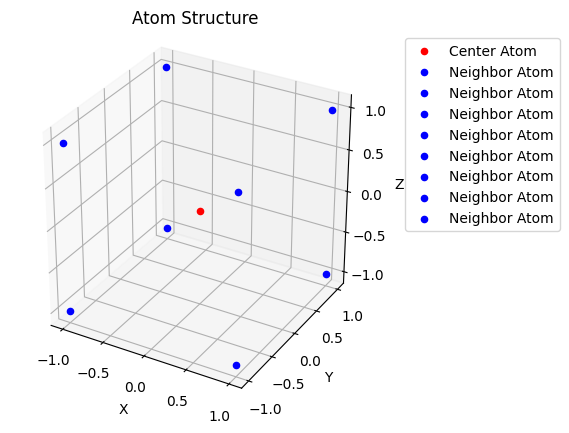

time: 752 ms (started: 2023-06-09 20:04:01 +00:00)


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the coordinates of the center atom
center_atom = [0, 0, 0]
# Define the coordinates of the eight neighboring atoms
neighbors = [
    [1, 1, 1],
    [1, 1, -1],
    [1, -1, 1],
    [1, -1, -1],
    [-1, 1, 1],
    [-1, 1, -1],
    [-1, -1, 1],
    [-1, -1, -1]
]
# Create a figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the center atom
ax.scatter(center_atom[0], center_atom[1], center_atom[2], color='red', label='Center Atom')
# Plot the neighboring atoms
for neighbor in neighbors:
    atom_x = center_atom[0] + neighbor[0]
    atom_y = center_atom[1] + neighbor[1]
    atom_z = center_atom[2] + neighbor[2]
    ax.scatter(atom_x, atom_y, atom_z, color='blue', label='Neighbor Atom')

# Set the axes labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# Set the aspect ratio to equal
ax.set_box_aspect([1, 1, 1])
# Set the plot title
ax.set_title('Atom Structure')
# Add a legend outside the figure
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Show the plot
plt.show()

In [ ]:
# Create NumPy arrays for x_k, y_k, z_k
x_k = np.array([center_atom[0] + neighbor[0] for neighbor in neighbors])
y_k = np.array([center_atom[1] + neighbor[1] for neighbor in neighbors])
z_k = np.array([center_atom[2] + neighbor[2] for neighbor in neighbors])

# Calculate r_ik
r_ik_array = np.sqrt(x_k**2 + y_k**2 + z_k**2)
R_cut = 2
r_0_array = np.full((r_ik_array.shape),R_cut)
#Calculate angels
theta_0_array = np.pi*(np.divide(r_ik_array,r_0_array))
z_k_abs_array = np.abs(z_k)
theta_array = np.arccos(np.divide(z_k_abs_array,r_ik_array))
phi_array = np.arctan(np.divide(y_k, x_k))
#convert angle to positive value between [0,2pi]
phi_array_convert = np.mod(phi_array, 2*np.pi)
w_ik_array = np.full((r_ik_array.shape),1)
delta = np.full((r_ik_array.shape),1)

time: 15.7 ms (started: 2023-06-09 20:07:58 +00:00)


In [ ]:
w_ik_array = np.full((r_ik_array.shape),1)
delta-a = np.full((r_ik_array.shape),1)

SyntaxError: ignored

time: 3.14 ms (started: 2023-06-09 19:36:05 +00:00)


In [ ]:
data_cube_8 = {
    'w_ik': np.full((r_ik_array.shape),1),  #set all neighbor atoms wik = 1
    'delta': np.full((r_ik_array.shape),1), #set delta = 1
    'r_ik': r_ik_array,
    'r_cut': r_0_array,
    'theta_0': theta_0_array,
    'theta': theta_array,
    'phi': phi_array_convert
}


time: 853 µs (started: 2023-06-09 20:19:44 +00:00)


In [ ]:
#Test bispectrum calculation
B= Bispectrum(j=5/2, j1=4/2, j2=1/2, params=data_cube_8)
B1 = B.evaluate(j=5/2, j1=4/2, j2=1/2, params=data_cube_8)
print(B1)

(0.0002660442377184137-5.89534931288993e-19j)
time: 113 ms (started: 2023-06-09 20:22:27 +00:00)


In [ ]:
#Test bispectrum calculation
B2= Bispectrum(j=5/2, j1=3/2, j2=2/2, params=data_cube_8)
B2 = B2.evaluate(j=5/2, j1=3/2, j2=2/2, params=data_cube_8)
print(B2)

(0.0002660442377184137-1.0977546996415732e-18j)
time: 137 ms (started: 2023-06-09 20:25:33 +00:00)
